# Stima dei livelli di obesità in base alle abitudini alimentari e alle condizioni fisiche
Progetto di Programmazione di Applicazioni Data Intensive - 2022/2023

**Realizzato da:** Fabio Veroli fabio.veroli@studio.unibo.it

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## Caricamento dei dati
L'obbiettivo del problema che andremo a studiare è stimare il livello di obesità di una persona in base alle sue abitudini alimentari e alle sue condizioni fisiche. 

Il dataset utilizzato, consultabile presso [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/544/estimation+of+obesity+levels+based+on+eating+habits+and+physical+condition), riguarda i dati di circa 2000 individui provenienti da Messico, Peru e Colombia; il 23% dei dati è stato ottenuto da un sondaggio online, mentre il restante 77% è stato generato sinteticamente utilizzando lo strumento Weka e il filtro SMOTE. 

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/Fab-Ver/DataIntensive-Project/main/data/ObesityDataSet.csv", delimiter=',')
df.head()

,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,Female,21.0,1.62,64.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,0.0,1.0,no,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,yes,no,3.0,3.0,Sometimes,yes,3.0,yes,3.0,0.0,Sometimes,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,yes,no,2.0,3.0,Sometimes,no,2.0,no,2.0,1.0,Frequently,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,no,no,3.0,3.0,Sometimes,no,2.0,no,2.0,0.0,Frequently,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,no,no,2.0,1.0,Sometimes,no,2.0,no,0.0,0.0,Sometimes,Public_Transportation,Overweight_Level_II


### Significato delle colonne
Le feature presenti nel dataset sono: 
- `Gender`: genere dell'individuo. Possibili valori: Female o Male
- `Age`: età dell'individuo (valore numerico)
- `Height`: altezza dell'individuo in metri (valore numerico)
- `Weight`: peso dell'individuo in chilogrammi (valore numerico)
- `family_history_with_overweight`: indica se nella famiglia dell'individuo sono presenti altri familiari che soffrono di obesità. Possibili valori: yes o no
- `FAVC`: indica se l'individuo consuma frequentemente cibi ad alto contenuto calorico. Possibili valori: yes o no
- `FCVC`: indica quanto spesso l'individuo mangia verdure durante i pasti. Possibili valori: Never (1), Sometimes (2), Always (3)
- `NCP`: numero di pasti principali consumati dall'individuo in un giorno (valore numerico)
- `CAEC`: indica quanto spesso l'individuo consuma cibi tra due pasti. Possibili valori: No, Sometimes, Frequently, Always
- `SMOKE`: indica se l'individuo fuma. Possibili valori: yes o no
- `CH20`: indica il consumo giornaliero di acqua. Possibili valori: less than a liter (1), between 1 and 2L (2), more than 2L (3)
- `SCC`: indica se l'individuo monitora le calorie che assume giornalmente. Possibili valori: yes o no
- `FAF`: indica il numero di giorni in una settimana in cui l'individuo effettua attività fisica. Possibili valori: never (0), 1-2 days (1), 2-4 days (2), 4-5 days (3)
- `TUE`: indica il numero di ore giornaliere passate utilizzando dispositivi tecnologici come cellulare, videogiochi, televisione, computer. Possibili valori: 0-2 hours (0), 3-5 hours (1), more than 5 hours (2)
- `CALC`: indica quanto spesso l'individuo consuma alcol. Possibili valori: No, Sometimes, Frequently, Always
- `MTRANS`: tipo di mezzo di trasporto utilizzato dall'individuo. Possibili valori: Public_Transportation, Walking, Automobile, Motorbike, Bike

La variabile che tenteremo di predirre è: 
- `NObeyesdad`: classificazione dei livelli di obesità basata sull'indice di massa corporea (BMI) secondo la WHO e la normativa messicana.

Modificihiamo i nomi delle colonne per renderli più esplicativi al fine dello studio del problema. 

In [3]:
col_names = {
    "Gender" : "gender",
    "Age" : "age",
    "Height" : "height",
    "Weight" : "weight",
    "family_history_with_overweight" : "overweight_in_family",
    "FAVC" : "high_caloric_food_frequently",
    "FCVC" : "freq_vegetables_cons",
    "NCP" : "num_meals",
    "CAEC" : "freq_cons_food_between_meals",
    "SMOKE" : "smoke",
    "CH2O" : "water_cons",
    "SCC" : "cal_cons_monitoring",
    "FAF" : "freq_physical_activity",
    "TUE" : "time_using_technology",
    "CALC" : "freq_alcohol_cons",
    "MTRANS" : "transportation",
    "NObeyesdad": "BMI_classification",
}
df.rename(columns=col_names,inplace=True)

In [4]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   gender                        2111 non-null   object 
 1   age                           2111 non-null   float64
 2   height                        2111 non-null   float64
 3   weight                        2111 non-null   float64
 4   overweight_in_family          2111 non-null   object 
 5   high_caloric_food_frequently  2111 non-null   object 
 6   freq_vegetables_cons          2111 non-null   float64
 7   num_meals                     2111 non-null   float64
 8   freq_cons_food_between_meals  2111 non-null   object 
 9   smoke                         2111 non-null   object 
 10  water_cons                    2111 non-null   float64
 11  cal_cons_monitoring           2111 non-null   object 
 12  freq_physical_activity        2111 non-null   float64
 13  tim

Dall'analisi dell'utilizzo della memoria emerge che il dataframe occupa molto spazio in memoria a causa di alcune variabili rappresentate come oggetti. Passiamo quindi a classificare le variabili in categoriche, booleane e numerice, in modo da avere una rappresentazione in memoria più efficiente. 

In [5]:
cat_vars = ["gender",  "freq_cons_food_between_meals", "time_using_technology","freq_vegetables_cons",
            "water_cons", "freq_physical_activity", "freq_alcohol_cons",  
            "transportation", "BMI_classification"]
bool_vars = ["overweight_in_family", "high_caloric_food_frequently", "smoke", "cal_cons_monitoring"]
float_vars = ["height", "weight","age", "num_meals"]

Convertiamo tutte gli attributi con valori possibili `yes` o `no` in attributi booleani.

In [6]:
mapping = {"yes" : True, "no" : False}
for col_name in bool_vars: 
    df[col_name] = df[col_name].map(mapping)

Per uniformità di rappresentazione dei dati convertiamo le variabili `freq_cons_food_between_meals` e `freq_alcohol_cons` da stringhe a valori numerici, in modo che siano rappresentati come le altre variabili categoriche.

In [7]:
mapping_cat_to_num = {"no" : 0, "Sometimes" : 1, "Frequently" : 2, "Always" : 3}
df["freq_cons_food_between_meals"] = df["freq_cons_food_between_meals"].map(mapping_cat_to_num)
df["freq_alcohol_cons"] = df["freq_alcohol_cons"].map(mapping_cat_to_num)

for col_name in cat_vars:
    df[col_name] = df[col_name].astype('category')

Come si può notare, l'occupazione di memoria del dataset è stata drasticamente ridotta in seguito alle trasformazione effettuate sui dati .

In [8]:
df.info(memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2111 entries, 0 to 2110
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype   
---  ------                        --------------  -----   
 0   gender                        2111 non-null   category
 1   age                           2111 non-null   float64 
 2   height                        2111 non-null   float64 
 3   weight                        2111 non-null   float64 
 4   overweight_in_family          2111 non-null   bool    
 5   high_caloric_food_frequently  2111 non-null   bool    
 6   freq_vegetables_cons          2111 non-null   category
 7   num_meals                     2111 non-null   float64 
 8   freq_cons_food_between_meals  2111 non-null   category
 9   smoke                         2111 non-null   bool    
 10  water_cons                    2111 non-null   category
 11  cal_cons_monitoring           2111 non-null   bool    
 12  freq_physical_activity        2111 non-null   ca

In [9]:
df.head()

,gender,age,height,weight,overweight_in_family,high_caloric_food_frequently,freq_vegetables_cons,num_meals,freq_cons_food_between_meals,smoke,water_cons,cal_cons_monitoring,freq_physical_activity,time_using_technology,freq_alcohol_cons,transportation,BMI_classification
0,Female,21.0,1.62,64.0,True,False,2.0,3.0,1,False,2.0,False,0.0,1.0,0,Public_Transportation,Normal_Weight
1,Female,21.0,1.52,56.0,True,False,3.0,3.0,1,True,3.0,True,3.0,0.0,1,Public_Transportation,Normal_Weight
2,Male,23.0,1.80,77.0,True,False,2.0,3.0,1,False,2.0,False,2.0,1.0,2,Public_Transportation,Normal_Weight
3,Male,27.0,1.80,87.0,False,False,3.0,3.0,1,False,2.0,False,2.0,0.0,2,Walking,Overweight_Level_I
4,Male,22.0,1.78,89.8,False,False,2.0,1.0,1,False,2.0,False,0.0,0.0,1,Public_Transportation,Overweight_Level_II


### Note

Le variabili  `time_using_technology`, `freq_vegetables_cons`, `water_cons`, `freq_physical_activity` vengono presentate dal creatore del dataset come variabili categoriche che assumono valori interi nell'intervallo [0,3] per indicare diverse risposte fornite dall'utente. Nella rappresentazione effettiva del dataset, queste variabili possono assumere anche valori continui, probabilemente influenzati dal 77% dei dati generati sinteticamente. In seguito a varie prove, in cui i dati sono stati corretti per farli rientrare nei valori interi oppure in cui i dati sono stati rappresentati come valori continui anziché categorici, si è infine deciso di mantenere la rappresentazione fornita dal dataset caricato e considerare queste variabili come categoriche, poiché hanno dimostarto migliori prestazioni nei modelli studiati successivamente.

Tuttavia, questa scelta influisce sul numero di variabili create; infatti,utilizzando il `OneHotEncoder`, come indicato di seguito, verrà generata una variabile con possibili valori [0,1] per ogni categoria, aumentando così il carico di dati da eleborare da parte dei vari modelli. Nonostante ciò, come già chiarito precedentemente, si è scelta questa soluzione per motivi di prestazioni dei modelli. 

Per le stesse motivazioni espresse in precedenza, le variabili `age` e `num_meals` vengono rappresentate come variaibli continue (float) anziché come variabili intere, come ci si aspetterebbe in un contesto reale. 

Per la variabile `transportation`, si è deciso di mantenere la rappresentazione dei dati sotto forma di stringhe, per una maggiore chiarezza nella lettura dei dati. 

## Analisi Esplorativa

Eseguiamo un'analisi di base dei dati, in particolare visualizziamo il numero e la distribuzione delle classi. 

In [10]:
len(df["BMI_classification"].unique())

7

In totale abbiamo 7 classi che individuano il livello di obesità di una persona, visualizziamo il numero di elementi per ogni classe e la loro distribuzione all'interno del dataset. 

In [11]:
df["BMI_classification"].value_counts()

Obesity_Type_I         351
Obesity_Type_III       324
Obesity_Type_II        297
Overweight_Level_I     290
Overweight_Level_II    290
Normal_Weight          287
Insufficient_Weight    272
Name: BMI_classification, dtype: int64

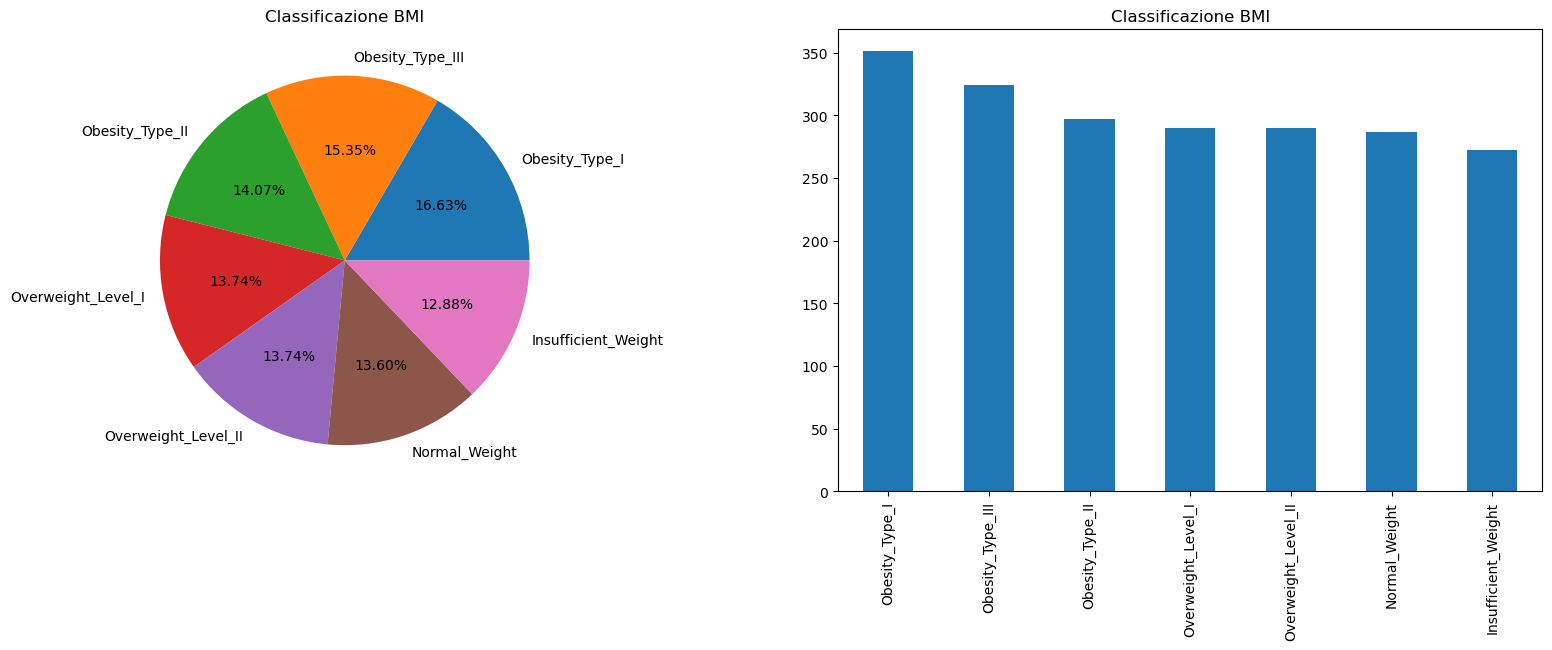

In [12]:
plt.figure(figsize=(20, 6))
df["BMI_classification"].value_counts().plot.pie(autopct="%.2f%%",ylabel="",title="Classificazione BMI",ax=plt.subplot(1, 2, 1));
df["BMI_classification"].value_counts().plot.bar(title="Classificazione BMI",ax=plt.subplot(1, 2, 2));

Come si può notare dai grafici, le classi sono pressochè bilanciate. Ci aspettavamo questo risultato poichè, come indicato nel dataset, il 77% dei dati è stato generato sintenticamente proprio allo scopo di bilanciare le classi e ottenere migliori prestazioni del dataset. Nella sua forma originale, il dataset era composto solo dai dati raccolti tramite sondaggi e presentava uno sbilanciamento con predominanza della classe `Normal`.

Possiamo poi ottenere e visualizzare in un grafico alcune statistiche su età, peso, altezza e numero di pasti consumati da parte di un individuo. 

In [13]:
df.describe()

,age,height,weight,num_meals
count,2111.000000,2111.000000,2111.000000,2111.000000
mean,24.312600,1.701677,86.586058,2.685628
std,6.345968,0.093305,26.191172,0.778039
min,14.000000,1.450000,39.000000,1.000000
25%,19.947192,1.630000,65.473343,2.658738
50%,22.777890,1.700499,83.000000,3.000000
75%,26.000000,1.768464,107.430682,3.000000
max,61.000000,1.980000,173.000000,4.000000


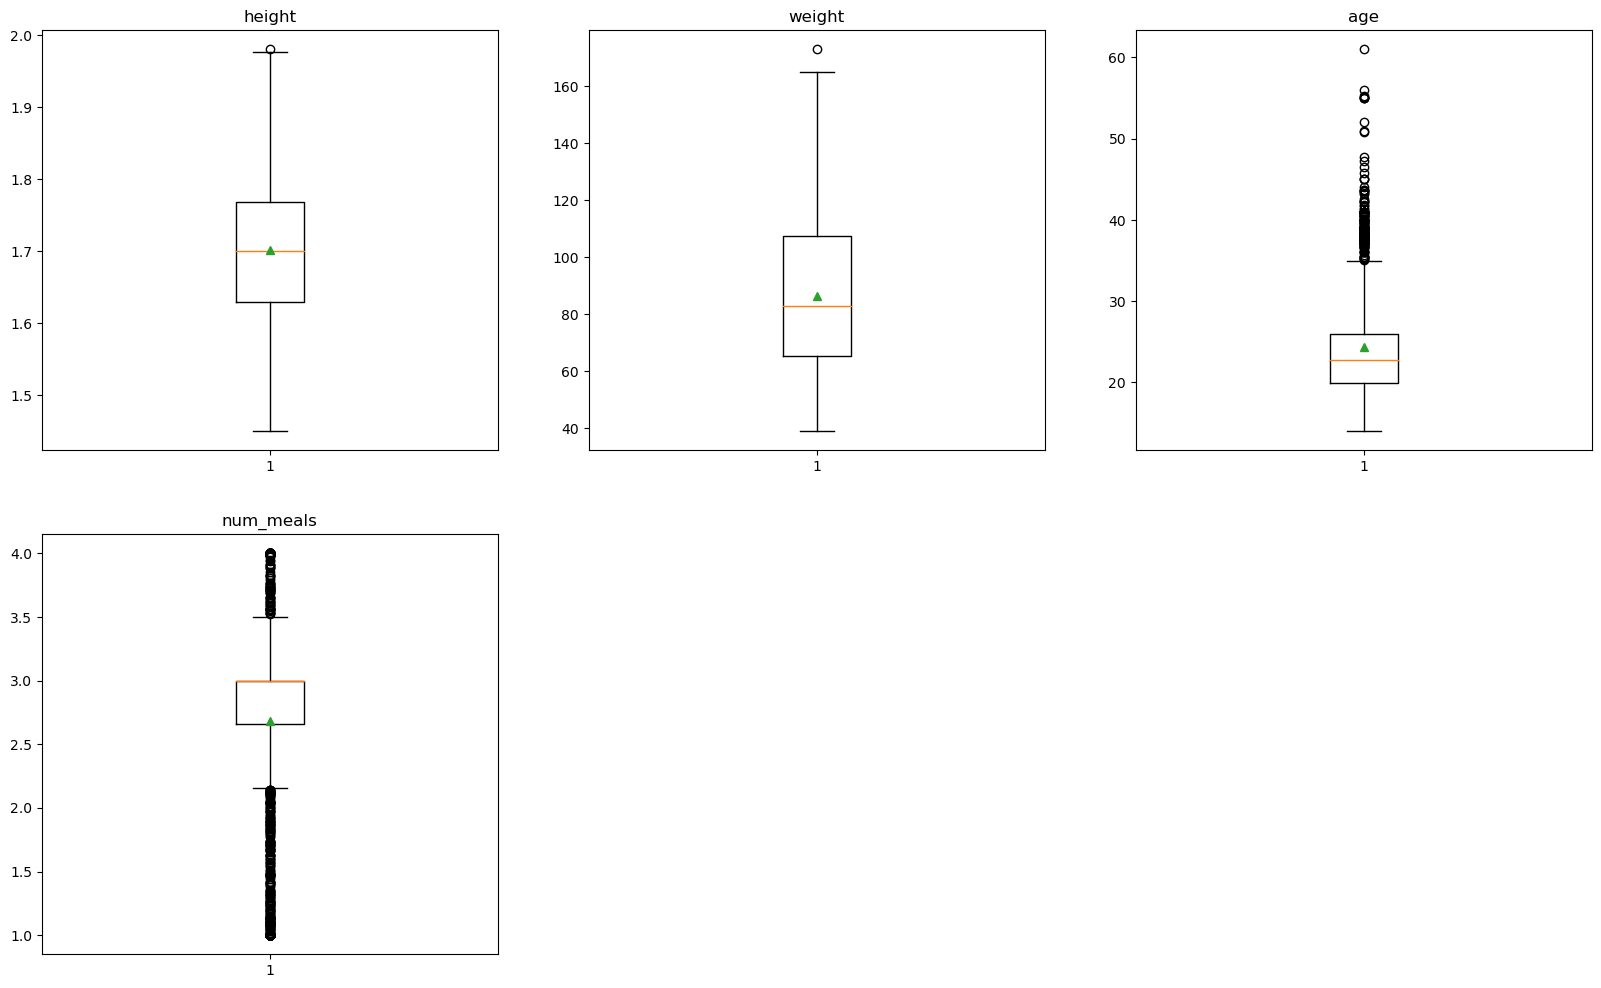

In [14]:
plt.figure(figsize=(20, 12))
for i, col in enumerate(float_vars,start=1):
    plt.subplot(2,3,i,title=col).boxplot(df[col],showmeans=True);

Dai grafici si nota che le serie `age` e `num_meals` presentano dati molto distanti dalla mediana (outlier).

Visualizziamo ora la correlazione tra la variabile target `BMI_classification` e l'indice di massa corporea (BMI) calcolato come $\frac{\text{Weight}}{\text{Height}\times \text{Height}}$

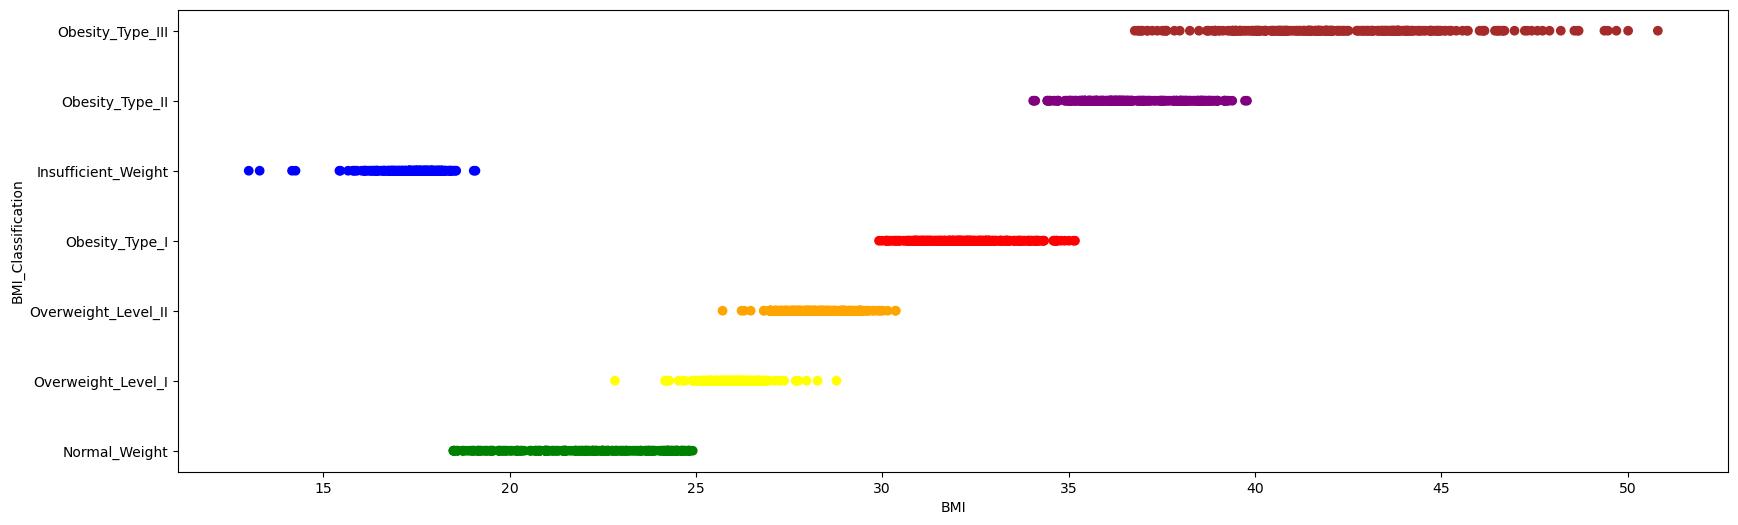

In [15]:
class_colors = df["BMI_classification"].map({
    'Normal_Weight': 'Green',
    'Overweight_Level_I': 'Yellow',
    'Overweight_Level_II': 'Orange',
    'Obesity_Type_I': 'Red',
    'Insufficient_Weight': 'Blue',
    'Obesity_Type_II': 'Purple',
    'Obesity_Type_III': 'Brown'
})
plt.figure(figsize=(20, 6))
plt.scatter(df["weight"]/(df["height"]**2),df["BMI_classification"],c=class_colors);
plt.xlabel("BMI");
plt.ylabel("BMI_Classification");

Dal grafico si può notare la correlazione lineare tra la `BMI_classification` e $\frac{\text{Weight}}{\text{Height}\times \text{Height}}$, ovvero il BMI di un individuo, utilizzato per classificare il livello di obesità. Solo i dati appartenenti alla classe `Insufficient_Weight` sembrano non seguire la stessa tendenza degli altri.

## Preparazione dei dati

Prepariamo i dati per l'addestramento dei modelli. Separiamo la variabile target `BMI_classification` dalle restanti variabili. 

In [16]:
X = df.drop(columns=["BMI_classification"])
y = df["BMI_classification"]

In [17]:
X.head()

,gender,age,height,weight,overweight_in_family,high_caloric_food_frequently,freq_vegetables_cons,num_meals,freq_cons_food_between_meals,smoke,water_cons,cal_cons_monitoring,freq_physical_activity,time_using_technology,freq_alcohol_cons,transportation
0,Female,21.0,1.62,64.0,True,False,2.0,3.0,1,False,2.0,False,0.0,1.0,0,Public_Transportation
1,Female,21.0,1.52,56.0,True,False,3.0,3.0,1,True,3.0,True,3.0,0.0,1,Public_Transportation
2,Male,23.0,1.80,77.0,True,False,2.0,3.0,1,False,2.0,False,2.0,1.0,2,Public_Transportation
3,Male,27.0,1.80,87.0,False,False,3.0,3.0,1,False,2.0,False,2.0,0.0,2,Walking
4,Male,22.0,1.78,89.8,False,False,2.0,1.0,1,False,2.0,False,0.0,0.0,1,Public_Transportation


In [18]:
y.head()

0          Normal_Weight
1          Normal_Weight
2          Normal_Weight
3     Overweight_Level_I
4    Overweight_Level_II
Name: BMI_classification, dtype: category
Categories (7, object): ['Insufficient_Weight', 'Normal_Weight', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III', 'Overweight_Level_I', 'Overweight_Level_II']

Suddividiamo il dataset in training e test set. 

In [19]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=1/3, random_state=42)

## Modelli

Addestriamo e validiamo i seguenti modelli di predizione:
- `Perceptron`
- `LogisticRegression`
- `DecisionTreeClassifier`

Importiamo le librerie che utilizzeremo in seguito

In [20]:
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline

Definiamo una funzione, comune per ogni modello studiato, che, dato il modello e la griglia degli iperparametri, effettui una ricerca degli iperparametri che massimizzano le prestazioni del modello. Utilizziamo `GridSearchCV` per la ricerca degli iperparametri con `StratifiedKFold` con k=3.

In [21]:
skf = StratifiedKFold(3, shuffle=True, random_state=42)

def grid_search(model, grid):
    gs = GridSearchCV(model, grid, cv=skf, n_jobs=-1, scoring="accuracy")
    gs.fit(X_train, y_train)
    return gs

Per verificare l'affidabilità dei modelli nella predizioni, utilizziamo come metriche la matrice di confusione, la precision, il recall e il f1-score.

In [22]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

def get_confusion_matrix(model):
    y_pred = model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    return pd.DataFrame(cm, index=model.classes_,columns=model.classes_)

def get_precision_recall_f1(model):
    y_pred = model.predict(X_test)
    stats = pd.DataFrame([precision_score(y_test,y_pred,average=None), recall_score(y_test,y_pred,average=None), f1_score(y_test,y_pred,average=None)],index=["Precision","Recall","F1"],columns=model.classes_)
    average_stats = pd.Series([precision_score(y_test,y_pred,average="macro"), recall_score(y_test,y_pred,average="macro"), f1_score(y_test,y_pred,average="macro")],index=["Precision","Recall","F1"])
    return stats, average_stats

Definiamo un filtro per la trasformazione dei dati tramite `ColumnTransformer`, il filtro è comune a tutti i modelli. La configurazione dei filtri da utilizzare per i vari tipi di variabile viene valutata all'interno della `GridSearchCV`, insieme agli altri iperparametri. 

In [23]:
preprocessor = ColumnTransformer([
    ("numeric", ..., float_vars),
    ("boolean",..., bool_vars),
    ("categorical", OneHotEncoder(handle_unknown='ignore'), [c for c in cat_vars if c != "BMI_classification"] )
])

### Perceptron

Iniziamo lo studio dei modelli di classificazione partendo da un modello di classificazione lineare, il Perceptron. 

Definiamo la griglia degli iperparametri da valutare. 

In [24]:
perceptron_model = Pipeline([
    ("preprocessor", preprocessor),
    ("perceptron", Perceptron(random_state=42))
])

perceptron_grid = [
    {
        "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
        "preprocessor__boolean" : ["passthrough", StandardScaler()],
        "preprocessor__categorical__drop" : [None, "first"],
        'perceptron__penalty': ['l1', 'l2'],
        'perceptron__alpha': np.logspace(-5, 3, 9),
        'perceptron__fit_intercept': [False, True],
    },
    {
        "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
        "preprocessor__boolean" : ["passthrough", StandardScaler()],
        "preprocessor__categorical__drop" : [None, "first"],
        'perceptron__penalty': ['elasticnet'],
        'perceptron__alpha': np.logspace(-5, 3, 9),
        'perceptron__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'perceptron__fit_intercept': [False, True],
    },
    {
        "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
        "preprocessor__boolean" : ["passthrough", StandardScaler()],
        "preprocessor__categorical__drop" : [None, "first"],
        'perceptron__penalty': [None],
    }
]

Effettuiamo la ricerca dei migliori iperparametri per `Perceptron`.

In [25]:
perceptron_gs = grid_search(perceptron_model, perceptron_grid)
best_perceptron_model = perceptron_gs.best_estimator_
print(f"Punteggio medio della cross validation per Perceptron: {perceptron_gs.best_score_:.4f}")

Punteggio medio della cross validation per Perceptron: 0.7392


I migliori iperparametri trovati sono: 

In [26]:
perceptron_gs.best_params_

{'perceptron__alpha': 1e-05,
 'perceptron__fit_intercept': True,
 'perceptron__penalty': 'l1',
 'preprocessor__boolean': StandardScaler(),
 'preprocessor__categorical__drop': None,
 'preprocessor__numeric': StandardScaler()}

Valutiamo ora il modello sul test set. 

In [27]:
print(f"Accuratezza di Perceptron sul test set: {best_perceptron_model.score(X_test,y_test):.4f}")

Accuratezza di Perceptron sul test set: 0.6903


Calcoliamo ora la matrice di confusione e le altre metriche per la valutazione del modello. 

In [28]:
get_confusion_matrix(best_perceptron_model)

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Insufficient_Weight,85,5,0,0,0,0,0
Normal_Weight,9,80,9,0,0,6,1
Obesity_Type_I,0,0,52,8,12,23,19
Obesity_Type_II,0,0,6,88,2,0,0
Obesity_Type_III,0,0,0,1,115,0,0
Overweight_Level_I,11,12,11,0,1,46,13
Overweight_Level_II,4,6,15,0,3,41,20


In [29]:
perceptron_stats, perceptron_average_stats = get_precision_recall_f1(best_perceptron_model)

In [30]:
perceptron_stats

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Precision,0.779817,0.776699,0.559140,0.907216,0.864662,0.396552,0.377358
Recall,0.944444,0.761905,0.456140,0.916667,0.991379,0.489362,0.224719
F1,0.854271,0.769231,0.502415,0.911917,0.923695,0.438095,0.281690


In [31]:
perceptron_average_stats

Precision    0.665921
Recall       0.683517
F1           0.668759
dtype: float64

Il modello non presenta buone prestazioni, sopratutto per la classificazione delle classi `Obesity_Type_I`, `Overweight_Level_I` e `Overweight_Level_II`, che tendono ad essere classificate in livelli superiori/inferiori riseptto alla classificazione BMI.

Come già trattato in precedenza, il modo in cui sono codificate le variabili genera un numero elevato di features. 

In [32]:
len(best_perceptron_model["preprocessor"].get_feature_names_out())

3021

Visualizziamo l'importanza di ciascuna features nel predirre il valore di ciascuna classe. 

In [39]:
perceptron_features = pd.DataFrame(best_perceptron_model["perceptron"].coef_.T,index=best_perceptron_model["preprocessor"].get_feature_names_out(), columns=best_perceptron_model["perceptron"].classes_)
perceptron_features

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
numeric__height,14.119121,1.324229,-3.808131,-5.471726,-5.201162,1.042084,-2.458580
numeric__weight,-53.267636,-20.401269,9.121404,20.206601,14.798633,0.284235,-0.099200
numeric__age,-5.945365,-0.960060,-4.340810,1.268632,-0.814454,0.005551,1.446666
numeric__num_meals,-2.030351,-0.221861,0.000000,-2.170440,5.147447,-0.239677,0.855894
boolean__overweight_in_family,-2.923662,0.000000,3.410327,0.066912,2.094594,4.098053,1.485666
...,...,...,...,...,...,...,...
categorical__transportation_Automobile,-3.760810,-10.746780,-1.549840,-7.746750,-4.901510,-2.563830,-0.760820
categorical__transportation_Bike,0.000000,-14.747530,-10.554040,2.747420,-0.908590,8.567190,-7.763050
categorical__transportation_Motorbike,-10.763360,-7.747060,9.553060,-6.748290,0.000000,-9.568040,0.000000
categorical__transportation_Public_Transportation,-6.760820,-9.746740,-5.549760,-1.746740,-3.901530,-0.563850,-1.760810


Consideriamo ora, ad esempio, la classe `Obesity_Type_II` e visualizziamo le feature che hanno minormente e maggiormente influenzato la predizione. 

In [91]:
perceptron_features["Obesity_Type_II"].sort_values(ascending=False)

numeric__weight                                 20.206601
categorical__time_using_technology_2.0          10.747110
categorical__water_cons_1.0                      6.746760
categorical__water_cons_1.725226                 5.758030
categorical__freq_physical_activity_0.356288     5.758030
                                                  ...    
categorical__freq_physical_activity_1.0         -9.746740
categorical__freq_vegetables_cons_3.0           -9.746760
categorical__freq_cons_food_between_meals_2    -10.746760
categorical__freq_vegetables_cons_2.0          -17.746750
categorical__gender_Female                     -20.746760
Name: Obesity_Type_II, Length: 3021, dtype: float64

Notiamo che tra le feature che influiscono posivitamente possiamo trovare la variabile `weight`, mentre fra quelle che influiscono negativamente la variabile categorica `gender`.

### LogisticRegression

Valutiamo ora un modello di regressione logisitica, utilizzando `LogisticRegression`

Definiamo la griglia degli iperparametri da valutare. 

In [72]:
logistic_regression_model = Pipeline([
    ("preprocessor", preprocessor),
    ("lregr", LogisticRegression(random_state=42, solver="saga"))
])

logistic_regression_grid = [
    {
        "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
        "preprocessor__boolean" : ["passthrough", StandardScaler()],
        "preprocessor__categorical__drop" : [None, "first"],
        'lregr__penalty': ['l1', 'l2'],
        'lregr__C': np.logspace(-5, 3, 9),
        'lregr__fit_intercept': [False, True],
    },
    {
        "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
        "preprocessor__boolean" : ["passthrough", StandardScaler()],
        "preprocessor__categorical__drop" : [None, "first"],
        'lregr__penalty': ['elasticnet'],
        'lregr__C': np.logspace(-5, 3, 9),
        'lregr__l1_ratio': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9],
        'lregr__fit_intercept': [False, True],
    },
    {
        "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
        "preprocessor__boolean" : ["passthrough", StandardScaler()],
        "preprocessor__categorical__drop" : [None, "first"],
        'lregr__penalty': [None],
    }
]

Inseriamo le seguenti linee di codice per ignorare i `ConvergenceWarning` generati durante la ricerca degli iperparametri migliori. 

In [82]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter(action='ignore', category=ConvergenceWarning)

Effettuiamo la ricerca dei migliori iperparametri per `LogisticRegression`.

In [83]:
logr_gs = grid_search(logistic_regression_model, logistic_regression_grid)
best_logr_model = logr_gs.best_estimator_
print(f"Punteggio medio della cross validation per LogisticRegression: {logr_gs.best_score_:.4f}")

Punteggio medio della cross validation per LogisticRegression: 0.9289


I migliori iperparametri trovati sono: 

In [84]:
logr_gs.best_params_

{'lregr__C': 1.0,
 'lregr__fit_intercept': False,
 'lregr__penalty': 'l1',
 'preprocessor__boolean': 'passthrough',
 'preprocessor__categorical__drop': None,
 'preprocessor__numeric': StandardScaler()}

Valutiamo ora il modello sul test set. 

In [85]:
print(f"Accuratezza di LogisticRegression sul test set: {best_logr_model.score(X_test,y_test):.4f}")

Accuratezza di LogisticRegression sul test set: 0.9332


Già dal valore dell'accuratezza ottenuto si può notare un notevole miglioramento delle prestazioni del modello `LogisticRegression` rispetto al modello `Perceptron`.

Calcoliamo ora la matrice di confusione e le altre metriche per la valutazione del modello.

In [86]:
get_confusion_matrix(best_logr_model)

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Insufficient_Weight,86,4,0,0,0,0,0
Normal_Weight,7,94,0,0,0,4,0
Obesity_Type_I,0,0,109,2,0,0,3
Obesity_Type_II,0,0,1,95,0,0,0
Obesity_Type_III,0,0,0,1,115,0,0
Overweight_Level_I,0,13,0,0,0,76,5
Overweight_Level_II,0,0,2,0,0,5,82


In [87]:
logr_stats, logr_average_stats = get_precision_recall_f1(best_logr_model)

In [88]:
logr_stats

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Precision,0.924731,0.846847,0.973214,0.969388,1.000000,0.894118,0.911111
Recall,0.955556,0.895238,0.956140,0.989583,0.991379,0.808511,0.921348
F1,0.939891,0.870370,0.964602,0.979381,0.995671,0.849162,0.916201


In [89]:
logr_average_stats

Precision    0.931344
Recall       0.931108
F1           0.930754
dtype: float64

Dai dati ottenuti si può notare un notevole miglioramento nella previsione della giusta classe di appartenenza, in particolare per i valori delle classi per le quali, invece, si erano ottenuti risultati insoddisfacenti con il modello `Perceptron`. Gli errori di classificazione ancora presenti riguardano solo la classe inferiore o superiore a quella da prevedere. Svantaggi del modello `LogisticRegressor` è il tempo impiegato per la ricerca degli iperparametri migliori che è maggiore di circa 10 volte rispetto al tempo impiegato con `Perceptron`.

### DecisionTreeClassifier

Infine, valutiamo un modello di classificazione basato su alberi decisionali, il `DecisionTreeClassifier`.

Definiamo la griglia degli iperparametri da valutare. 

In [121]:
dtc_model = Pipeline([
    ("preprocessor", preprocessor),
    ("dtc", DecisionTreeClassifier(random_state=42))
])

dtc_grid = {
    "preprocessor__numeric" : ["passthrough", StandardScaler(), MinMaxScaler()],
    "preprocessor__boolean" : ["passthrough", StandardScaler()],
    #"preprocessor__categorical__drop" : [None, "first"],
    "dtc__max_depth" : [None, 10, 20, 30],
    "dtc__criterion": ['gini', 'entropy', 'log_loss'],
    "dtc__min_samples_split" : [2, 5, 10],
    "dtc__min_samples_leaf" : [1, 2, 4],
    "dtc__max_features" : [None, 'sqrt', 'log2'],
}

Effettuiamo la ricerca dei migliori iperparametri per `DecisionTreeClassifier`.

In [122]:
dtc_gs = grid_search(dtc_model, dtc_grid)
best_dtc_model = dtc_gs.best_estimator_
print(f"Punteggio medio della cross validation per DecisionTreeClassifier: {dtc_gs.best_score_:.4f}")

Punteggio medio della cross validation per DecisionTreeClassifier: 0.9296


I migliori iperparametri trovati sono: 

In [123]:
dtc_gs.best_params_

{'dtc__criterion': 'entropy',
 'dtc__max_depth': 10,
 'dtc__max_features': None,
 'dtc__min_samples_leaf': 1,
 'dtc__min_samples_split': 5,
 'preprocessor__boolean': 'passthrough',
 'preprocessor__numeric': StandardScaler()}

Inseriamo le seguenti linee di codice per ignorare gli `UserWarning`, che si presentano a causa del parametro `drop="first"` utilizzato in `OneHotEncoder`.

In [124]:
warnings.simplefilter(action='ignore', category=UserWarning)

Valutiamo ora il modello sul test set. 

In [125]:
print(f"Accuratezza di DecisionTreeClassifier sul test set: {best_dtc_model.score(X_test,y_test):.4f}")

Accuratezza di DecisionTreeClassifier sul test set: 0.9446


Calcoliamo ora la matrice di confusione e le altre metriche per la valutazione del modello.

In [126]:
get_confusion_matrix(best_dtc_model)

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Insufficient_Weight,90,0,0,0,0,0,0
Normal_Weight,7,94,0,0,0,4,0
Obesity_Type_I,0,0,108,3,0,3,0
Obesity_Type_II,0,0,6,90,0,0,0
Obesity_Type_III,0,0,0,1,115,0,0
Overweight_Level_I,0,6,0,0,0,84,4
Overweight_Level_II,0,0,2,0,0,3,84


In [127]:
dtc_stats, dtc_average_stats = get_precision_recall_f1(best_dtc_model)

In [128]:
dtc_stats

,Insufficient_Weight,Normal_Weight,Obesity_Type_I,Obesity_Type_II,Obesity_Type_III,Overweight_Level_I,Overweight_Level_II
Precision,0.927835,0.940000,0.931034,0.957447,1.000000,0.893617,0.954545
Recall,1.000000,0.895238,0.947368,0.937500,0.991379,0.893617,0.943820
F1,0.962567,0.917073,0.939130,0.947368,0.995671,0.893617,0.949153


In [129]:
dtc_average_stats

Precision    0.943497
Recall       0.944132
F1           0.943511
dtype: float64

Anche in questo caso, notiamo un miglioramento nella previsione della classe di apparteenza rispetto ai modelli precedentemente ottenuti con `Perceptron` e `LogisticRegression`. Tutte le classi presentano statistiche pressoché uniformi. Inoltre, il tempo impiegato per individuare gli iperparametri del modello è simile a quello impiegato da `Perceptron`, a differenza del tempo estremamente maggiore richiesto da `LogisticRegression` per ottenere prestazioni comparabili. 

Visualizziamo l'albero decisionale ottenuto. 

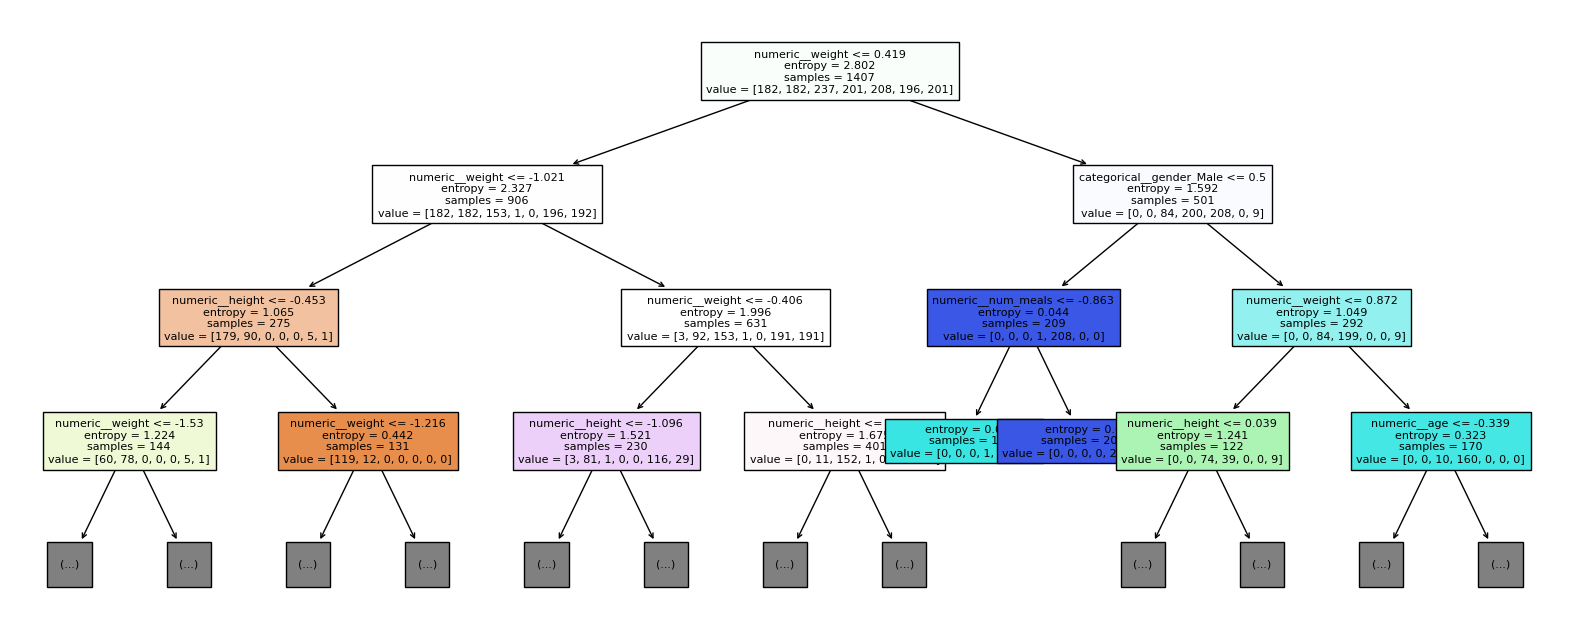

In [135]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20, 8))
plot_tree(best_dtc_model["dtc"], feature_names=best_dtc_model["preprocessor"].get_feature_names_out().tolist(), max_depth=3, filled=True, fontsize=8);

## Conclusioni 